In [86]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy import stats
from geopy.distance import geodesic
import math
from scipy.spatial.distance import cdist
import seaborn as sns

In [87]:
bikes = pd.read_csv("C:/Users/Laura/Downloads/DSML/Project/bluebikes_2021.csv")
weather = pd.read_csv("C:/Users/Laura/Downloads/DSML/Project/boston_weather.csv")
pois = pd.read_csv("C:/Users/Laura/Downloads/DSML/Project/pois.csv")

C:\Users\Laura\AppData\Local\Temp\ipykernel_10664\4071934133.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  bikes = pd.read_csv("C:/Users/Laura/Downloads/DSML/Project/bluebikes_2021.csv")
C:\Users\Laura\AppData\Local\Temp\ipykernel_10664\4071934133.py:3: DtypeWarning: Columns (10,12,13,14,21,22,25,26,28,29,31,32,33,34,35,36,37,39,40,41,43,44,45,48,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,70,71,72,74,75,76,77,78,79,80,81,82,84,85,88,89,90,91,92,93,94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  pois = pd.read_csv("C:/Users/Laura/Downloads/DSML/Project/pois.csv")


# Data Collection and Preparation


## Bluebikes 

In [88]:
bikes.info()
bikes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2934388 entries, 0 to 2934387
Data columns (total 10 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Unnamed: 0         int64  
 1   start_time         object 
 2   end_time           object 
 3   start_station_id   int64  
 4   start_station_lat  float64
 5   start_station_lon  float64
 6   end_station_id     object 
 7   end_station_lat    float64
 8   end_station_lon    float64
 9   bike_id            int64  
dtypes: float64(4), int64(3), object(3)
memory usage: 223.9+ MB


,Unnamed: 0,start_time,end_time,start_station_id,start_station_lat,start_station_lon,end_station_id,end_station_lat,end_station_lon,bike_id
0,0,2021-01-01 00:00:04,2021-01-01 00:15:19,91,42.366277,-71.091690,370,42.350961,-71.077828,5316
1,1,2021-01-01 00:00:21,2021-01-01 00:18:27,370,42.350961,-71.077828,169,42.378965,-71.068607,4917
2,2,2021-01-01 00:00:26,2021-01-01 00:16:12,46,42.343666,-71.085824,21,42.346520,-71.080658,2881
3,3,2021-01-01 00:00:30,2021-01-01 00:06:26,178,42.359573,-71.101295,107,42.362500,-71.088220,4792
4,4,2021-01-01 00:01:11,2021-01-01 00:09:43,386,42.368605,-71.099302,413,42.369553,-71.085790,6062
...,...,...,...,...,...,...,...,...,...,...
2934383,2934373,2021-12-31 23:58:38,2022-01-01 00:06:38,4,42.345392,-71.069616,415,42.349544,-71.072421,4895
2934384,2934374,2021-12-31 23:58:46,2022-01-01 00:11:24,77,42.386844,-71.098120,96,42.373379,-71.111075,3665
2934385,2934375,2021-12-31 23:58:49,2022-01-01 00:03:30,338,42.348359,-71.139972,8,42.353334,-71.137313,6470
2934386,2934376,2021-12-31 23:59:50,2022-01-01 00:01:49,32,42.343691,-71.102353,19,42.347241,-71.105301,6484


#### Change 'start_time' and 'end_time' from object to datetime

In [89]:
# We want to change the data type of the variables start_time and end_time from objects to datetime
# In order to do that first we have to deal with the inconsistencies in the columns start_time and end_time 
# Some of the entries don't follow the format year-month-day; hours:minutes:seconds, so we need to change the format
# by creating a function that replaces the slashes (/) with colons (:) of some values 

def substitute_slashes(data, column):
    data[column] = data[column].str.replace('/', ':')
    return data

substitute_slashes(bikes, 'start_time')
substitute_slashes(bikes, 'end_time')

,Unnamed: 0,start_time,end_time,start_station_id,start_station_lat,start_station_lon,end_station_id,end_station_lat,end_station_lon,bike_id
0,0,2021-01-01 00:00:04,2021-01-01 00:15:19,91,42.366277,-71.091690,370,42.350961,-71.077828,5316
1,1,2021-01-01 00:00:21,2021-01-01 00:18:27,370,42.350961,-71.077828,169,42.378965,-71.068607,4917
2,2,2021-01-01 00:00:26,2021-01-01 00:16:12,46,42.343666,-71.085824,21,42.346520,-71.080658,2881
3,3,2021-01-01 00:00:30,2021-01-01 00:06:26,178,42.359573,-71.101295,107,42.362500,-71.088220,4792
4,4,2021-01-01 00:01:11,2021-01-01 00:09:43,386,42.368605,-71.099302,413,42.369553,-71.085790,6062
...,...,...,...,...,...,...,...,...,...,...
2934383,2934373,2021-12-31 23:58:38,2022-01-01 00:06:38,4,42.345392,-71.069616,415,42.349544,-71.072421,4895
2934384,2934374,2021-12-31 23:58:46,2022-01-01 00:11:24,77,42.386844,-71.098120,96,42.373379,-71.111075,3665
2934385,2934375,2021-12-31 23:58:49,2022-01-01 00:03:30,338,42.348359,-71.139972,8,42.353334,-71.137313,6470
2934386,2934376,2021-12-31 23:59:50,2022-01-01 00:01:49,32,42.343691,-71.102353,19,42.347241,-71.105301,6484


In [90]:
# Now we can transform the start_time and end_time columns to the proper format with the pd.to_datatime method

bikes[['start_time','end_time']] = bikes[['start_time','end_time']].apply(pd.to_datetime)

In [91]:
# We can use the info() method to assure that the data types of the variables start_time and end_time have been changed

bikes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2934388 entries, 0 to 2934387
Data columns (total 10 columns):
 #   Column             Dtype         
---  ------             -----         
 0   Unnamed: 0         int64         
 1   start_time         datetime64[ns]
 2   end_time           datetime64[ns]
 3   start_station_id   int64         
 4   start_station_lat  float64       
 5   start_station_lon  float64       
 6   end_station_id     object        
 7   end_station_lat    float64       
 8   end_station_lon    float64       
 9   bike_id            int64         
dtypes: datetime64[ns](2), float64(4), int64(3), object(1)
memory usage: 223.9+ MB


#### Change 'end_station_id' to integer

In [92]:
# We also want to change the data type of the variable end_station_id to an integer (it should be the same as start_station_id)
# This inconsistency is because some of the values in the column end_station_id are not in the proper format,
# instead of being whole numers some of them have quote symbols (""), which makes transform the column into an object type
# We create a function that eliminates the quote marks of the numbers

def remove_quotes(data, column):
    data[column] = data[column].apply(lambda x: x.replace('"', '') if isinstance(x, str) else x)
    return data

bikes = remove_quotes(bikes, 'end_station_id')

In [93]:
# Once all the values in the column have the same format then we can proceed to transform the data type of the variable to integer

bikes['end_station_id'] = bikes['end_station_id'].apply('int64')

In [94]:
# We can use the info() method to confirm that the type of the variable 'end_station_id' has been changed

bikes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2934388 entries, 0 to 2934387
Data columns (total 10 columns):
 #   Column             Dtype         
---  ------             -----         
 0   Unnamed: 0         int64         
 1   start_time         datetime64[ns]
 2   end_time           datetime64[ns]
 3   start_station_id   int64         
 4   start_station_lat  float64       
 5   start_station_lon  float64       
 6   end_station_id     int64         
 7   end_station_lat    float64       
 8   end_station_lon    float64       
 9   bike_id            int64         
dtypes: datetime64[ns](2), float64(4), int64(4)
memory usage: 223.9 MB


#### Create variable 'idle_time'

In [95]:
# We want to create a new variable that contains the average idle time of a bike for each station 
# First we need to calculate the idle time for every bike

# 1. We sort the data by bike_id and end_time
bikes.sort_values(['bike_id', 'end_time'], inplace=True)

# 2. Group the data by bike_id
grouped = bikes.groupby('bike_id')

# 3. Calculate the idle time for each bike by subtracting end_time to start_time and store in a new variable called idle_time
bikes['idle_time'] = grouped['start_time'].shift(-1) - bikes['end_time']

# 4. Set the idle time to 0 for the last bike usage
bikes.loc[grouped['bike_id'].cumcount() == grouped['bike_id'].transform('size') - 1, 'idle_time'] = pd.Timedelta(0)

# 5. Reset the dataframe index
bikes.reset_index(drop=True, inplace=True)

In [96]:
# We can check the idle time of every bike 

bikes[['bike_id', 'start_station_id','end_station_id','idle_time']]

,bike_id,start_station_id,end_station_id,idle_time
0,218,171,397,2 days 15:08:02
1,218,397,176,0 days 06:14:03
2,218,176,76,0 days 00:36:50
3,218,76,54,0 days 01:09:53
4,218,54,56,3 days 18:48:35
...,...,...,...,...
2934383,7665,74,333,1 days 07:35:35
2934384,7665,333,76,0 days 00:07:32
2934385,7665,76,189,1 days 22:43:09
2934386,7665,116,68,0 days 00:01:16


In [97]:
# Second we want to sum all the idle time for every station

# 1. Sort for end_station_id
bikes.sort_values(['end_station_id'], inplace=True)

# 2. Group the data by end_station_id and calculate the sum of idle time
station_idle_sum = bikes.groupby('end_station_id')['idle_time'].sum()

# 3. Reset the index and rename the columns
station_idle_sum = station_idle_sum.reset_index()
station_idle_sum.columns = ['station_id', 'idle_time_sum']

# Now we have the total idle time for every station
station_idle_sum

,station_id,idle_time_sum
0,1,2319 days 09:23:43
1,3,2894 days 10:37:18
2,4,4750 days 06:43:39
3,5,1908 days 00:44:29
4,6,2990 days 23:36:04
...,...,...
422,548,6 days 00:50:59
423,549,1131 days 08:26:23
424,550,116 days 16:48:14
425,553,394 days 13:38:19


In [98]:
# We also want the mean idle time of every station, so we group the data by end_station_id and calculate the average idle time
station_idle_mean = bikes.groupby('end_station_id')['idle_time'].mean()

# Reset the index and rename the columns
station_idle_mean = station_idle_mean.reset_index()
station_idle_mean.columns = ['station_id', 'idle_time_mean']

# We convert the idle time to hours and specify we want maximum two decimals for simplicity
station_idle_mean['idle_time_mean'] = (station_idle_mean['idle_time_mean'].dt.total_seconds() / 60).round(2)

# Now we have the mean idle time in hours for every station

station_idle_mean

,station_id,idle_time_mean
0,1,4613.15
1,3,451.03
2,4,555.41
3,5,188.11
4,6,204.90
...,...,...
422,548,1241.57
423,549,600.50
424,550,638.97
425,553,1044.45


In [99]:
# We also calculate the median for the idle time

station_idle_median = bikes.groupby('end_station_id')['idle_time'].median().reset_index()
station_idle_median.columns = ['station_id', 'idle_time_median']

station_idle_median['idle_time_median'] = (station_idle_median['idle_time_median'].dt.total_seconds() / 60).round(2)

station_idle_median

,station_id,idle_time_median
0,1,2067.05
1,3,146.00
2,4,116.91
3,5,52.24
4,6,46.03
...,...,...
422,548,199.03
423,549,233.77
424,550,412.08
425,553,675.64


In [100]:
# Now we want to create a data frame that contains all the station_id with their respective latitudes and longitudes and
# that then we will merge with all the idle time information

station_ids = sorted(pd.concat([bikes['start_station_id'], bikes['end_station_id']]).unique())
stations = pd.DataFrame({'station_id': station_ids})

stations['lat'] = 0.0
stations['lon'] = 0.0

for index, row in stations.iterrows():
    station_id = row['station_id']
    station_data = bikes[(bikes['start_station_id'] == station_id) | (bikes['end_station_id'] == station_id)].iloc[0]
    if station_data['start_station_id'] == station_id:
        stations.loc[index, 'lat'] = station_data['start_station_lat']
        stations.loc[index, 'lon'] = station_data['start_station_lon']
    else:
        stations.loc[index, 'lat'] = station_data['end_station_lat']
        stations.loc[index, 'lon'] = station_data['end_station_lon']  

In [101]:
# Finally we merge all data sets into one 

stations = stations.assign(idle_time_sum=station_idle_sum['idle_time_sum'],
                           idle_time_mean=station_idle_mean['idle_time_mean'],
                          idle_time_median=station_idle_median['idle_time_median'])

stations

,station_id,lat,lon,idle_time_sum,idle_time_mean,idle_time_median
0,1,42.387151,-71.075978,2319 days 09:23:43,4613.15,2067.05
1,3,42.340115,-71.100619,2894 days 10:37:18,451.03,146.00
2,4,42.345392,-71.069616,4750 days 06:43:39,555.41,116.91
3,5,42.341814,-71.090179,1908 days 00:44:29,188.11,52.24
4,6,42.361257,-71.065287,2990 days 23:36:04,204.90,46.03
...,...,...,...,...,...,...
422,548,42.268100,-71.119240,6 days 00:50:59,1241.57,199.03
423,549,42.364739,-71.059349,1131 days 08:26:23,600.50,233.77
424,550,42.386400,-71.096010,116 days 16:48:14,638.97,412.08
425,553,42.371141,-71.076198,394 days 13:38:19,1044.45,675.64


## Weather

In [102]:
weather.info()
weather.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82777 entries, 0 to 82776
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   city                     82777 non-null  object 
 1   timestamp                82777 non-null  object 
 2   temperature              82773 non-null  float64
 3   cloud_cover              82777 non-null  int64  
 4   cloud_cover_description  82777 non-null  object 
 5   pressure                 82768 non-null  float64
 6   windspeed                82740 non-null  float64
 7   precipitation            82777 non-null  float64
 8   felt_temperature         82752 non-null  float64
dtypes: float64(5), int64(1), object(3)
memory usage: 5.7+ MB


,city,timestamp,temperature,cloud_cover,cloud_cover_description,pressure,windspeed,precipitation,felt_temperature
0,Boston,2015-01-01 05:54:00,-6.0,29,Partly Cloudy,1018.58,17.0,0.0,-12.0
1,Boston,2015-01-01 06:54:00,-6.0,27,Mostly Cloudy,1017.90,17.0,0.0,-12.0
2,Boston,2015-01-01 07:54:00,-6.0,27,Mostly Cloudy,1017.22,19.0,0.0,-12.0
3,Boston,2015-01-01 08:54:00,-4.0,27,Mostly Cloudy,1016.55,20.0,0.0,-11.0
4,Boston,2015-01-01 09:54:00,-6.0,29,Partly Cloudy,1016.21,24.0,0.0,-13.0


In [103]:
# First we want to change the "timestamp" variable type from object to datetime with pd.to_datetime

weather['timestamp'] = pd.to_datetime(weather['timestamp'])

In [104]:
# Now we filter only the entries for the year 2021, since is the year we are interested in for our project   

weather = weather[weather['timestamp'].dt.year == 2021] 

In [105]:
# We look whether there are any null-values which we want to get rid of

missing_values = weather.isnull().sum() 
print(missing_values)

rows_with_missing_values = weather[weather.isnull().any(axis=1)]
print(rows_with_missing_values)

city                       0
timestamp                  0
temperature                2
cloud_cover                0
cloud_cover_description    0
pressure                   0
windspeed                  3
precipitation              0
felt_temperature           2
dtype: int64
         city           timestamp  temperature  cloud_cover  \
63950  Boston 2021-03-03 16:54:00          NaN           34   
66774  Boston 2021-06-17 17:54:00         25.0           34   
68871  Boston 2021-08-24 17:54:00         31.0           28   
70297  Boston 2021-10-14 17:54:00          NaN           34   

      cloud_cover_description  pressure  windspeed  precipitation  \
63950                    Fair   1008.09        NaN            0.0   
66774                    Fair   1011.81        NaN            0.0   
68871           Mostly Cloudy   1011.13        NaN            0.0   
70297                    Fair   1011.47       20.0            0.0   

       felt_temperature  
63950               NaN  
66774       

In [106]:
#  We drop all null-values and check if we successfully got rid of them

weather = weather.dropna()

missing_values = weather.isnull().sum()
print(missing_values)

city                       0
timestamp                  0
temperature                0
cloud_cover                0
cloud_cover_description    0
pressure                   0
windspeed                  0
precipitation              0
felt_temperature           0
dtype: int64


## Points of interest

In [107]:
# First we filter only the information for Boston, since we do not need the data of Massachusetts

pois = pois[pois['addr:city'] == "Boston"] 

In [108]:
pois.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1908 entries, 33 to 92230
Data columns (total 96 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          1908 non-null   int64  
 1   version             1908 non-null   int64  
 2   timestamp           1908 non-null   int64  
 3   changeset           1610 non-null   float64
 4   id                  1908 non-null   int64  
 5   tags                1861 non-null   object 
 6   lat                 1585 non-null   float64
 7   lon                 1585 non-null   float64
 8   addr:city           1908 non-null   object 
 9   addr:country        16 non-null     object 
 10  addr:full           1 non-null      object 
 11  addr:housenumber    1878 non-null   object 
 12  addr:housename      8 non-null      object 
 13  addr:postcode       1839 non-null   object 
 14  addr:place          1 non-null      object 
 15  addr:street         1900 non-null   object 
 16  emai

In [109]:
pois

,Unnamed: 0,version,timestamp,changeset,id,tags,lat,lon,addr:city,addr:country,...,geometry,osm_type,biergarten,theatre,agrarian,cosmetics,outdoor,swimming_pool,trade,water
33,33,6,1591763622,0.0,69504856,"{""addr:state"":""MA"",""attribution"":""massDOT"",""bu...",42.338516,-71.03127,Boston,NaN,...,POINT (-71.0312728881836 42.33851623535156),node,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84,84,4,1530115928,0.0,257486687,"{""addr:state"":""MA"",""attribution"":""Office of Ge...",42.299590,-71.10173,Boston,NaN,...,POINT (-71.10173034667969 42.299591064453125),node,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
90,90,6,1593727122,0.0,257486695,"{""addr:state"":""MA"",""attribution"":""Office of Ge...",42.292465,-71.10141,Boston,NaN,...,POINT (-71.10140991210938 42.29246520996094),node,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,96,5,1596134943,0.0,257486704,"{""addr:state"":""MA"",""attribution"":""Office of Ge...",42.367275,-71.06633,Boston,NaN,...,POINT (-71.06632995605469 42.36727523803711),node,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99,99,3,1530115932,0.0,257486710,"{""addr:state"":""MA"",""attribution"":""Office of Ge...",42.334450,-71.06774,Boston,NaN,...,POINT (-71.06774139404297 42.334449768066406),node,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92220,92220,10,1680275378,0.0,7547154230,"{""addr:state"":""MA"",""site"":""school"",""type"":""site""}",NaN,NaN,Boston,NaN,...,"MULTIPOLYGON (((-71.0829577 42.3490254, -71.08...",relation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92221,92221,5,1596311865,0.0,9405156098,"{""addr:state"":""MA"",""contact:facebook"":""https:/...",NaN,NaN,Boston,NaN,...,"POLYGON ((-71.0784068 42.3501667, -71.0784356 ...",relation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92222,92222,6,1638386222,0.0,9427558974,"{""addr:state"":""MA"",""type"":""multipolygon""}",NaN,NaN,Boston,NaN,...,"MULTIPOLYGON (((-71.030267 42.3720275, -71.030...",relation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92224,92224,5,1644043877,0.0,9696493087,"{""addr:state"":""MA"",""air_conditioning"":""yes"",""b...",NaN,NaN,Boston,NaN,...,"POLYGON ((-71.0841867 42.3458082, -71.0841551 ...",relation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Exploring the variables

In [110]:
# We want to explore the different categories of the variables that have more non-null values and we think are more relevant

categories_amenity =  pois['amenity'].unique()
categories_amenity

array(['bus_station', 'prison', 'hospital', 'police', 'school',
       'fire_station', 'library', nan, 'bank', 'post_office',
       'place_of_worship', 'university', 'college', 'parking',
       'restaurant', 'bar', 'cafe', 'pub', 'social_facility',
       'ferry_terminal', 'fast_food', 'cinema', 'parking_entrance',
       'community_centre', 'bicycle_rental', 'clinic', 'bicycle_parking',
       'dentist', 'social_centre', 'pharmacy', 'ice_cream', 'car_rental',
       'nightclub', 'fuel', 'theatre', 'atm', 'boat_rental',
       'planetarium', 'doctors', 'internet_cafe', 'veterinary',
       'concert_hall', 'childcare', 'car_sharing', 'loading_dock',
       'music_venue', 'food_court', 'dojo', 'post_box', 'language_school',
       'kindergarten', 'charging_station', 'biergarten',
       'research_institute', 'telephone', 'vending_machine',
       'payment_terminal', 'music_school', 'studio', 'recycling',
       'marketplace', 'driving_school', 'courthouse', 'post_depot',
       'monast

In [111]:
categories_shop = pois['shop'].unique()
categories_shop 

array([nan, 'hardware', 'car_repair', 'hifi', 'hairdresser', 'outdoor',
       'supermarket', 'clothes', 'books', 'mobile_phone', 'convenience',
       'electronics', 'dry_cleaning', 'music', 'chemist', 'pastry',
       'furniture', 'health_food', 'vacant', 'beauty', 'alcohol',
       'optician', 'bicycle', 'newsagent', 'laundry', 'charity',
       'Athletics', 'locksmith', 'chocolate', 'jewelry', 'wine',
       'massage', 'fashion_accessories', 'bakery', 'florist', 'copyshop',
       'sports', 'outdoor;sports', 'department_store', 'cosmetics',
       'lamps', 'gift', 'yes', 'greengrocer', 'shoes', 'car', 'paint',
       'nutrition_supplements', 'video_games', 'candles', 'tea',
       'interior_decoration', 'tailor', 'bag', 'craft', 'pet', 'bed',
       'leather', 'pet_grooming', 'frame', 'lighting', 'tobacco',
       'pawnbroker', 'watches', 'window_blind', 'baby_goods',
       'confectionery', 'coffee', 'ticket', 'variety_store', 'carpet',
       'stationery', 'perfumery', 'kiosk', '

In [112]:
categories_tourism =  pois['tourism'].unique()
categories_tourism

array([nan, 'museum', 'hotel', 'attraction', 'information', 'gallery',
       'apartment', 'aquarium', 'hostel', 'guest_house', 'viewpoint'],
      dtype=object)

In [113]:
categories_religion = pois['religion'].unique()
categories_religion

array([nan, 'none', 'christian', 'unitarian_universalist', 'jewish',
       'Universalist'], dtype=object)

In [114]:
# After making some exploration we can see that some of the variables are included in other categories
# This overlap makes the information redundant, so we will only choose a specific set of those variables 
# that contain more information and we think are relevant for our analysis

# After making a selection of the columns that we want we create a new dataframe

columns_needed = ['lat','lon','amenity','shop','tourism', 'religion']
new_pois = pois[columns_needed]

In [115]:
new_pois

,lat,lon,amenity,shop,tourism,religion
33,42.338516,-71.03127,bus_station,NaN,NaN,NaN
84,42.299590,-71.10173,prison,NaN,NaN,NaN
90,42.292465,-71.10141,prison,NaN,NaN,NaN
96,42.367275,-71.06633,prison,NaN,NaN,NaN
99,42.334450,-71.06774,prison,NaN,NaN,NaN
...,...,...,...,...,...,...
92220,NaN,NaN,college,NaN,NaN,NaN
92221,NaN,NaN,place_of_worship,NaN,NaN,christian
92222,NaN,NaN,university,NaN,NaN,NaN
92224,NaN,NaN,NaN,NaN,hotel,NaN


# Descriptive Analytics

## Points of Interest

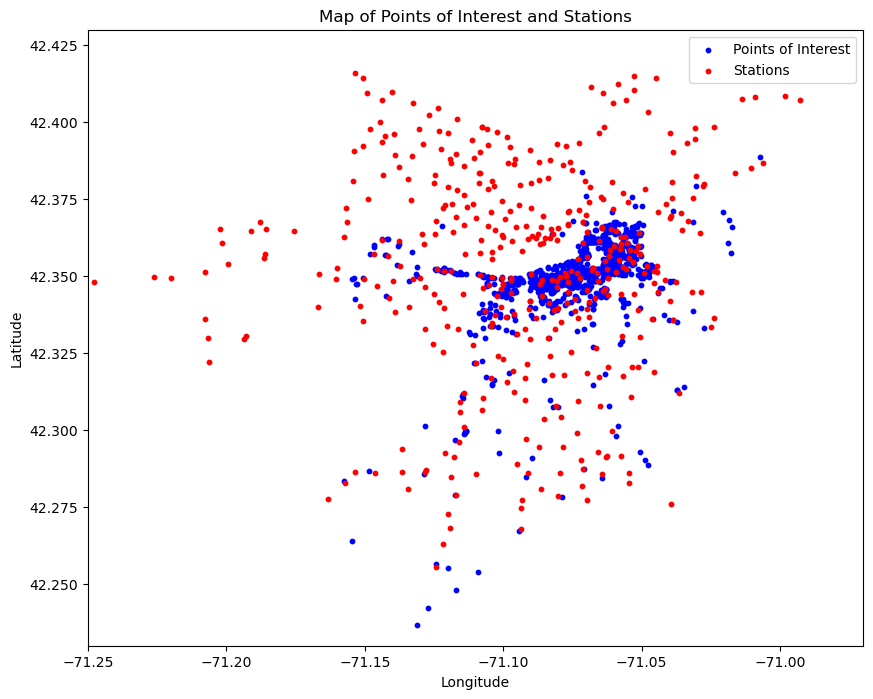

In [117]:
# We want to create a visual representation of how the stations and the points of interest are related with 
# each other geographycally 

# We create the graph
plt.figure(figsize=(10,8)) 

plt.scatter(new_pois['lon'], new_pois['lat'], color='blue', s=10, label='Points of Interest')
plt.scatter(stations['lon'], stations['lat'], color='red', s=10, label='Stations')

# We zoom in to see more details and ignore some of the outliers
lat_min, lat_max = 42.23, 42.43
lon_min, lon_max = -71.25, -70.97

filtered_amenities = new_pois[(new_pois['lat'] >= lat_min) & (new_pois['lat'] <= lat_max) &
                               (new_pois['lon'] >= lon_min) & (new_pois['lon'] <= lon_max)]

plt.xlim(lon_min, lon_max)
plt.ylim(lat_min, lat_max)

# We label the graph 
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Map of Points of Interest and Stations')
plt.legend()
plt.show()

# Now we can visually see how the stations and the different points of interest are approximatetly distributed throughout the city of Boston

In [118]:
# analysis of the graph:
# we can observe that the blue dots are much more concentrated in a much smaller area while the red dots are much more disperse
# this tells us that the majority of points of interested are probably located in more centric and urban areas
# and thus the stations around those areas have a much better access to services such as transport, supermarkets, etc.

# another thing to highlight is that in the north and west areas there are much less services and amenities (we can barely
# see any blue dots) while in the south and east of the city seems to be more
# we don't know what could be te possible explanation for that but we think is important to mention since
# there is clearly an pattern 


# this information leads us to the next hypothesis:
# there is a negative correlation between density of points of interest in a concrete area
# and the idle time of the stations in that area

# to see if that is the case and test our hypothesis we are going to use a density-based measure technique 
# to calculate the density of the points of interest and see how that correlates to the idle time

# then we will analyse some statistical measures to see if our conclusions can be extrapolated to the population 
# and we can reject the null hypothesis that says that there is no relationship between the variables

# the steps are the following:

#### 1) Calculate the density of points of interest around each bike station

In [38]:
# First we need to define the haversine function:

def haversine_distance(lat1, lon1, lat2, lon2):
    r = 6371  # radius of the Earth in kilometers

# Convert latitudes and longitudes from degrees to radians
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)

# Calculate differences
    delta_lat = lat2_rad - lat1_rad
    delta_lon = lon2_rad - lon1_rad

# Haversine formula
    a = math.sin(delta_lat / 2) ** 2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(delta_lon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

# Calculate distance
    distance = r * c
    return distance

In [39]:
# Define the radius for calculating density:

radius = 0.5

In [40]:
# Calculate the distance between each bike station and all points of interest using the haversine_distance function

stations_coords = stations[['lat', 'lon']].values
pois_coords = new_pois[['lat', 'lon']].values

distances = np.zeros((stations_coords.shape[0], pois_coords.shape[0]))

for i in range(stations_coords.shape[0]):
    for j in range(pois_coords.shape[0]):
        lat1, lon1 = stations_coords[i]
        lat2, lon2 = pois_coords[j]
        distances[i, j] = haversine_distance(lat1, lon1, lat2, lon2)

In [41]:
# Count the number of points of interest within the specified radius for each bike station:

density = np.sum(distances <= radius, axis=1)

#### Add the density information to the data frame

In [119]:
# We add the variable density to the data frame stations

stations['density'] = density
stations

,station_id,lat,lon,idle_time_sum,idle_time_mean,idle_time_median,density
0,1,42.387151,-71.075978,2319 days 09:23:43,4613.15,2067.05,0
1,3,42.340115,-71.100619,2894 days 10:37:18,451.03,146.00,36
2,4,42.345392,-71.069616,4750 days 06:43:39,555.41,116.91,72
3,5,42.341814,-71.090179,1908 days 00:44:29,188.11,52.24,21
4,6,42.361257,-71.065287,2990 days 23:36:04,204.90,46.03,109
...,...,...,...,...,...,...,...
422,548,42.268100,-71.119240,6 days 00:50:59,1241.57,199.03,0
423,549,42.364739,-71.059349,1131 days 08:26:23,600.50,233.77,88
424,550,42.386400,-71.096010,116 days 16:48:14,638.97,412.08,0
425,553,42.371141,-71.076198,394 days 13:38:19,1044.45,675.64,1


#### Analyze the relationship between density and idle time

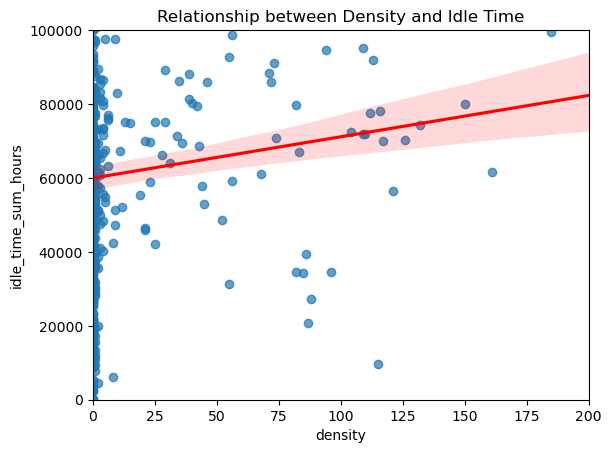

In [169]:
# Visualize the relationship between the density of points of interest and the idle time of stations using 
# scatter plots 

# First we are going to analyse the sum of the different idle times and compare them with the density

# Convert timedelta of the variable idle_time _sun to total hours

stations['idle_time_sum_hours'] = stations['idle_time_sum'].dt.total_seconds() // 60

# Customize scatter plot
plt.scatter(stations['density'], stations['idle_time_sum_hours'], alpha=0.7)
plt.xlabel('Density')
plt.ylabel('Idle Time (Hours)')
plt.title('Relationship between Density and Idle Time')

# Add regression line
sns.regplot(x='density', y='idle_time_sum_hours', data=stations, scatter=False, color='r')

# Set custom limits for x-axis and y-axis
x_min, x_max = 0, 200  # Adjust the range according to your data
y_min, y_max = 0, 100000  # Adjust the range according to your data
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.show()


#something here is not correct (the idle time doesn't make sense)


In [123]:
# amalysis: 
# as we saw in the previous graph, we can see that there are a lot of areas that have a really low density of
# amenities, services, etc. 
# meanwhile we can see that in those same areas there are stations that still being used (or have lower idle times)
# the results seems to contradict our hypothesis that higher density leads to lower idle time (negative relation between 
# the variables) 
# why those results contradit our hypothesis? maybe because we are using absolute values? variance worth analysing

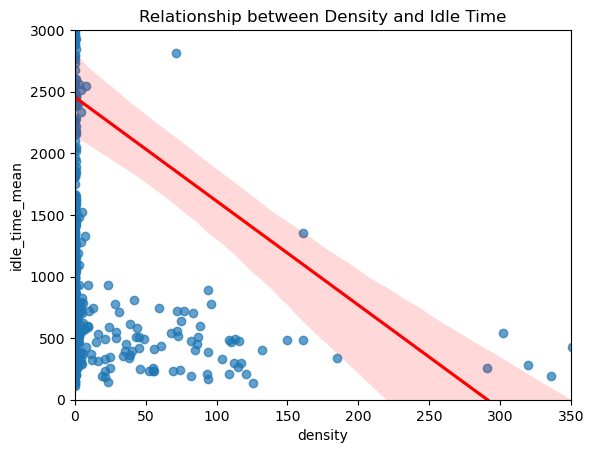

In [147]:
# We do the same but now with idle_time_mean

# Customize scatter plot
plt.scatter(stations['density'], stations['idle_time_mean'], alpha=0.7)
plt.xlabel('Density')
plt.ylabel('Idle Time Mean')
plt.title('Relationship between Density and Idle Time')

# Add regression line
sns.regplot(x='density', y='idle_time_mean', data=stations, scatter=False, color='r')

# Set custom limits for x-axis and y-axis
x_min, x_max = 0, 350  # Adjust the range according to your data
y_min, y_max = 0, 3000  # Adjust the range according to your data
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.show()

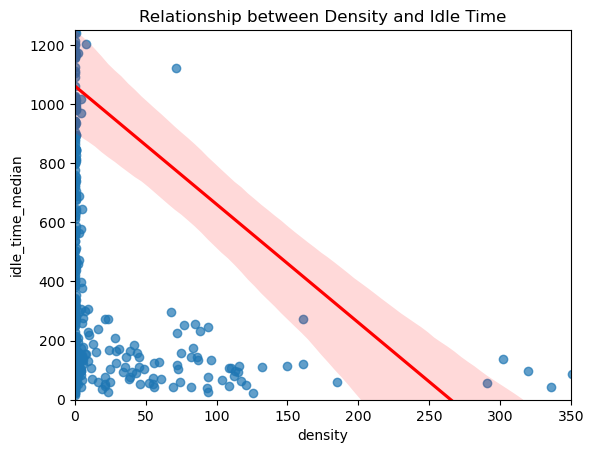

In [149]:
# Graph with idle_time_median

# Customize scatter plot
plt.scatter(stations['density'], stations['idle_time_median'], alpha=0.7)
plt.xlabel('Density')
plt.ylabel('Idle Time Median')
plt.title('Relationship between Density and Idle Time')

# Add regression line
sns.regplot(x='density', y='idle_time_median', data=stations, scatter=False, color='r')

# Set custom limits for x-axis and y-axis
x_min, x_max = 0, 350  # Adjust the range according to your data
y_min, y_max = 0, 1250  # Adjust the range according to your data
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.show()

In [ ]:
# Explore any trends or patterns that may suggest a relationship between the variables.

In [ ]:
# next step is to see if these relations are statistically significant

# Creating a dataframe for the Station locations

In [299]:
#We want to include the locations of the stations into our POIs dataframe to analyze the distances between them and other locations

In [ ]:
columns_need = ["end_station_id" ,"end_station_lat","end_station_lon"]#Create new dataframe with only one of each bike start_staion
bikes_loc=bikes[columns_need]

In [ ]:
bikes_loc.head()

In [ ]:
bikes_loc.sort_values("end_station_id", inplace=True)

In [30]:
bikes_loc = bikes_loc.drop_duplicates(subset='end_station_id', keep="last") #We want to get rif of duplicates since we need the stations only once


In [31]:
bikes_loc#here we see that each station is included once

,end_station_id,end_station_lat,end_station_lon
762232,1,42.387151,-71.075978
952393,3,42.340115,-71.100619
1891280,4,42.345392,-71.069616
2134183,5,42.341814,-71.090179
538784,6,42.361257,-71.065287
...,...,...,...
1255971,548,42.268100,-71.119240
2389382,549,42.364739,-71.059349
1027814,550,42.386400,-71.096010
928164,553,42.371141,-71.076198


In [32]:
bikes_loc.rename(columns={'end_station_lat':'lat'}, inplace=True)#rename "start_station_lat" and "start_station_lon" so it
bikes_loc.rename(columns={'end_station_lon':'lon'}, inplace=True)#fits the POIs dataframe

In [33]:
bikes_loc.head()

,end_station_id,lat,lon
762232,1,42.387151,-71.075978
952393,3,42.340115,-71.100619
1891280,4,42.345392,-71.069616
2134183,5,42.341814,-71.090179
538784,6,42.361257,-71.065287


In [34]:
pois_merged = filtered_pois.append(bikes_loc, ignore_index=True)#merge bikes_loc and POIs dataframe

C:\Users\Laura\AppData\Local\Temp\ipykernel_12104\2159903972.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pois_merged = filtered_pois.append(bikes_loc, ignore_index=True)#merge bikes_loc and POIs dataframe


In [35]:
pois_merged.head()

,lat,lon,addr:city,name,amenity,atm,bar,library,office,school,university,shop,tourism,end_station_id
0,42.248200,-71.11723,Boston,Boston Police Academy,school,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,42.336823,-71.09875,Boston,Morton R. Godine Library,library,NaN,NaN,NaN,Massachusetts College Of Art,NaN,NaN,NaN,NaN,NaN
2,42.350800,-71.06653,Boston,New England School of Law Library,library,NaN,NaN,NaN,New England School Of Law,NaN,NaN,NaN,NaN,NaN
3,42.357075,-71.14803,Boston,WGBH Media Library and Archives,library,NaN,NaN,special,NaN,NaN,NaN,NaN,NaN,NaN
4,42.362730,-71.06741,Boston,Treadwell Library,library,NaN,NaN,NaN,Massachusetts General Hospital,NaN,NaN,NaN,NaN,NaN


In [36]:
pois_merged.describe()

,lat,lon,end_station_id
count,776.000000,776.000000,427.000000
mean,42.351929,-71.083749,278.911007
std,0.031052,0.038877,172.864642
min,42.248200,-71.247759,1.000000
25%,42.343734,-71.102497,116.500000
50%,42.350701,-71.080181,279.000000
75%,42.363734,-71.062070,435.000000
max,42.534669,-70.870214,554.000000


In [37]:
bikes.rename(columns={'start_time':'timestamp'}, inplace=True)
bikes.head()

,Unnamed: 0,timestamp,end_time,start_station_id,start_station_lat,start_station_lon,end_station_id,end_station_lat,end_station_lon,bike_id,idle_time
270459,1747872,2021-09-04 08:45:47,2021-09-14 21:43:18,331,42.336586,-71.098870,1,42.387151,-71.075978,2530,4 days 19:09:59
1905792,465839,2021-05-01 20:13:21,2021-05-03 15:58:54,55,42.347406,-71.086784,1,42.387151,-71.075978,5646,0 days 07:40:44
1712012,49660,2021-01-21 13:22:09,2021-01-21 13:36:38,496,42.398444,-71.107833,1,42.387151,-71.075978,5333,6 days 07:06:28
1420535,1380703,2021-08-03 17:25:18,2021-08-03 17:47:06,139,42.361780,-71.108100,1,42.387151,-71.075978,4871,1 days 02:28:52
2485847,2711372,2021-11-18 11:23:27,2021-11-18 11:36:28,437,42.372077,-71.089954,1,42.387151,-71.075978,6557,2 days 03:54:18


In [58]:
bikes_idle_avg = bikes.groupby(pd.PeriodIndex(bikes['timestamp'], freq="D"))['idle_time'].mean() 
#here we calculate the bike idle time average for every week to see when the idle time was highest (season, weather ...)

In [59]:
weather_temp_avg = weather.groupby(pd.PeriodIndex(weather['timestamp'], freq="D"))['temperature'].mean() 
#here we calculate the weather average for every week, to merge it with the average idle time 

In [60]:


avg = weather_temp_avg.to_frame().join(bikes_idle_avg) #merged table for weather and bikes idle time average
avg



,temperature,idle_time
timestamp,,
2021-01-01,0.913043,1 days 21:44:59.355860612
2021-01-02,3.772727,1 days 09:59:51.970930232
2021-01-03,0.551724,1 days 15:01:11.825589225
2021-01-04,1.000000,1 days 01:09:16.912116484
2021-01-05,-0.250000,1 days 00:37:35.801775147
...,...,...
2021-12-27,0.640000,0 days 13:49:08.752860411
2021-12-28,2.648649,0 days 11:02:21.520513883
2021-12-29,4.862069,0 days 09:58:51.617318435


In [61]:
avg['idle_hours'] = avg['idle_time'] / pd.Timedelta(hours=1)
avg

,temperature,idle_time,idle_hours
timestamp,,,
2021-01-01,0.913043,1 days 21:44:59.355860612,45.749821
2021-01-02,3.772727,1 days 09:59:51.970930232,33.997770
2021-01-03,0.551724,1 days 15:01:11.825589225,39.019952
2021-01-04,1.000000,1 days 01:09:16.912116484,25.154698
2021-01-05,-0.250000,1 days 00:37:35.801775147,24.626612
...,...,...,...
2021-12-27,0.640000,0 days 13:49:08.752860411,13.819098
2021-12-28,2.648649,0 days 11:02:21.520513883,11.039311
2021-12-29,4.862069,0 days 09:58:51.617318435,9.981005


In [52]:
weather.corr().round() #a correlation table to see what column is correlating with which one

C:\Users\Laura\AppData\Local\Temp\ipykernel_12104\2971402967.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  weather.corr().round() #a correlation table to see what column is correlating with which one


,temperature,cloud_cover,pressure,windspeed,precipitation,felt_temperature
temperature,1.0,0.0,-0.0,-0.0,0.0,1.0
cloud_cover,0.0,1.0,0.0,-0.0,-0.0,0.0
pressure,-0.0,0.0,1.0,-0.0,-0.0,-0.0
windspeed,-0.0,-0.0,-0.0,1.0,0.0,-0.0
precipitation,0.0,-0.0,-0.0,0.0,1.0,0.0
felt_temperature,1.0,0.0,-0.0,-0.0,0.0,1.0


In [ ]:
correlation = avg['temperature'].corr(avg['idle_time'])

In [62]:

correlation = avg['idle_hours'].corr(avg['temperature'])
correlation

-0.7345051630666638

In [66]:
x = avg['temperature']
y = avg['idle_hours']
corr_coeff, p_value = stats.pearsonr(x, y)

p_value

4.2779167578427757e-63

In [ ]:
# idle time for every day for every station

In [81]:
station_ids = pd.concat([bikes['start_station_id'], bikes['end_station_id']]).unique()
stations = pd.DataFrame({'station_id': station_ids})

In [82]:
stations

,station_id
0,331
1,55
2,496
3,139
4,437
...,...
422,317
423,518
424,517
425,548


In [83]:
stations['start_station_lat'] = 0.0
stations['start_station_lon'] = 0.0
stations['end_station_lat'] = 0.0
stations['end_station_lon'] = 0.0

In [84]:
for index, row in stations.iterrows():
    station_id = row['station_id']

In [87]:
start_station_data = stations[stations['start_station_id'] == station_id].iloc[0]
end_station_data = stations[stations['end_station_id'] == station_id].iloc[0]

KeyError: 'start_station_id'

In [89]:
stations.loc[index, 'start_latitude'] = start_station_data['start_station_latitude']
stations.loc[index, 'start_longitude'] = start_station_data['start_station_longitude']
stations.loc[index, 'end_latitude'] = end_station_data['end_station_latitude']
stations.loc[index, 'end_longitude'] = end_station_data['end_station_longitude']

NameError: name 'start_station_data' is not defined